# Team #35

# María Paula Gutiérrez Cervantes - **A01747706**

# Juan Miguel Molina Reyes - **A01796655**

# Carlos Alberto Rocha Chávez - **A01796914**

# Jorge Andrés Santos Gordon - **A01652587**

# TC 5033
## Deep Learning
## Fully Connected Deep Neural Networks

#### Activity 1b: Implementing a Fully Connected Network for Kaggle ASL Dataset

- Objective

The aim of this part of the activity is to apply your understanding of Fully Connected Networks by implementing a multilayer network for the [Kaggle ASL (American Sign Language) dataset](https://www.kaggle.com/datasets/grassknoted/asl-alphabet). While you have been provided with a complete solution for a Fully Connected Network using Numpy for the MNIST dataset, you are encouraged to try to come up with the solution.

- Instructions

    This activity requires submission in teams of 3 or 4 members. Submissions from smaller or larger teams will not be accepted unless prior approval has been granted (only due to exceptional circumstances). While teamwork is encouraged, each member is expected to contribute individually to the assignment. The final submission should feature the best arguments and solutions from each team member. Only one person per team needs to submit the completed work, but it is imperative that the names of all team members are listed in a Markdown cell at the very beginning of the notebook (either the first or second cell). Failure to include all team member names will result in the grade being awarded solely to the individual who submitted the assignment, with zero points given to other team members (no exceptions will be made to this rule).

    Load and Preprocess Data: You are provided a starter code to load the data. Be sure to understand the code.

    Review MNIST Notebook (Optional): Before diving into this activity, you have the option to revisit the MNIST example to refresh your understanding of how to build a Fully Connected Network using Numpy.

    Start Fresh: Although you can refer to the MNIST solution at any point, try to implement the network for the ASL dataset on your own. This will reinforce your learning and understanding of the architecture and mathematics involved.

    Implement Forward and Backward Pass: Write the code to perform the forward and backward passes, keeping in mind the specific challenges and characteristics of the ASL dataset.
    
     Design the Network: Create the architecture of the Fully Connected Network tailored for the ASL dataset. Choose the number of hidden layers, neurons, and hyperparameters judiciously.

    Train the Model: Execute the training loop, ensuring to track performance metrics such as loss and accuracy.

    Analyze and Document: Use Markdown cells to document in detail the choices you made in terms of architecture and hyperparameters, you may use figures, equations, etc to aid in your explanations. Include any metrics that help justify these choices and discuss the model's performance.  

- Evaluation Criteria

    - Code Readability and Comments
    - Appropriateness of chosen architecture and hyperparameters for the ASL dataset
    - Performance of the model on the ASL dataset (at least 70% acc)
    - Quality of Markdown documentation

- Submission

Submit this Jupyter Notebook in canvas with your complete solution, ensuring your code is well-commented and includes Markdown cells that explain your design choices, results, and any challenges you encountered.


# Code Implementation

*The first step in the solution is to import several libraries, that will be used to build the functions. We import numpy and pandas for data structures and handling, as well as matplotlib for plotting examples, and sklearn for the splitting of the validation set.*

In [61]:
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import os
from sklearn.model_selection import train_test_split

%matplotlib inline


*As we are working with a Jupyter Notebook in Google Colab, the files will be temporarily uploaded to the content folder of Colab to read from directly. We have to set the path for both the Train and Validation datasets, and read them using the standard .read_csv function offered by pandas*

In [62]:
TRAIN_PATH = '/content/sign_mnist_train.csv'
VALID_PATH = '/content/sign_mnist_valid.csv'
train_df = pd.read_csv(TRAIN_PATH)
valid_df = pd.read_csv(VALID_PATH)

*As a good practice, we print the first 5 rows of the dataset to get a better understanding of the data. It has 785 columns, which represent 784 pixels and the label (letter of the alphabet based on an index)*

In [63]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,12,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


*To separate the label from the inputs, we create new y_train/val arrays, taking the only the "label" column from the original datasets. Afterwards, we delete the "label" column from the original arrays. Finally, we create the x/input dataframe using the astype command, which allows us to make the switch from pandas to numpy, making sure all values are converte to a 32-bit float number.*

In [64]:
y_train = np.array(train_df['label'])
y_val = np.array(valid_df['label'])
del train_df['label']
del valid_df['label']
x_train = train_df.values.astype(np.float32)
x_val = valid_df.values.astype(np.float32)

*At this point we only have two sets (train and validation). However, it is important to have a test set as well, that will provide the final metrics to measure the performance of the model. Using the train_test_split function from sklearn, we create a split_val_test function that takes x and y (data arrays) as arguments, a fixed pct of 0.5, and a shuffle of true, and returns those datesets divided into 4 datasets of equal size (x & y for test & validation). Later on, we call the function, sending the x_val and y_val datasets as arguments.*

In [65]:
def split_val_test(x, y, pct=0.5, shuffle=True):
    x_val, x_test, y_val, y_test = train_test_split(x, y, test_size=pct, random_state=42)
    return x_val, x_test, y_val, y_test

In [66]:
x_val, x_test, y_val, y_test = split_val_test(x_val, y_val)

*As we will be working with labels that represent letters of the alphabet, we import a list of letters from the string library, which pulls the ascii values. The ASL dataset doesn't include j or z, which is why those letters are removed from the list. We print the length of the alphabet list, which outputs a 24 (26 letters minus the 2 that were removed).*

In [67]:
alphabet=list(string.ascii_lowercase)
alphabet.remove('j')
alphabet.remove('z')
print(len(alphabet))

24


### Normalise


*Neural networks, specially those with He initialization, have very small values in their weights. Our inputs represent pixels, which range fro, 0 to 255 in value. If we don't normalise the values of the inputs, the result of the operations can fail due to lack of stability. In order to normalise, we first visualize the mean and standard deviation of the x_train array. We then define a normalise function, that takes a calculation of mean and standard deviation, and an array to be altered. In the function, the mean is substracted from the datapoints, and this is divided by the standard deviation. In term, this allows us to have a mean of 0 and a standard deviation of 1, which ensures that all values are between -1 and 1. We call the function on each of the 3 input arrays (train, test and validation), and do a final calculation of the mean and standard deviation to confirm the results are as expected.*

In [68]:
x_train.mean(), x_train.std(), x_train.min()

(np.float32(159.29083), np.float32(48.76953), np.float32(0.0))

In [69]:
def normalise(x_mean, x_std, x_data):
    return (x_data - x_mean) / x_std

In [70]:
x_mean = x_train.mean()
x_std = x_train.std()

x_train = normalise(x_mean, x_std, x_train)
x_val = normalise(x_mean, x_std, x_val)
x_test = normalise(x_mean, x_std, x_test)

In [71]:
x_train.mean(), x_train.std()

(np.float32(3.6268384e-06), np.float32(0.99999946))

### Plotting samples

*To get a first glimpse of samples, we need to plot a row/image of the dataset. We define a plot_number function, which takes an image as argument. We initialize a matplotlib plot, and using the imshow function, display it. When calling the function, we generate a random index (from 0 to the lenght of the test array), and we get the value of the label of that row. We use this value as a further index to get the corresponding value in the alphabet list and print it. Finally, we call the original index from the x_test dataset, and reshape it from 784 to 28x28, which are the dimensions of the image.*

In [72]:
def plot_number(image):
    plt.figure(figsize=(5,5))
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

The image shown represents letter : b


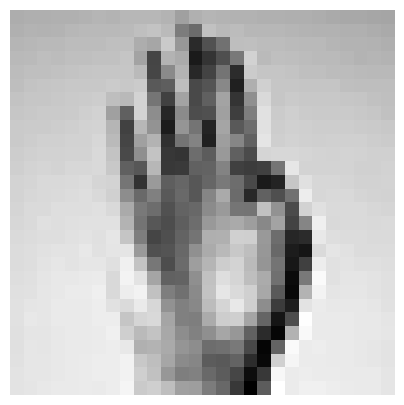

In [73]:
idx = np.random.randint(len(y_test))
print(f'The image shown represents letter : {alphabet[y_test[idx]]}')
plot_number(x_test[idx].reshape(28,28))

### Model equations


$$z^1 = W^1 X + b^1$$

$$a^1 = ReLU(z^1) $$

$$z^2 = W^2 a^1 + b^2$$

$$\hat{y} = \frac{e^{z^{2_k}}}{\sum_j{e^{z_j}}}$$


$$ \mathcal{L}(\hat{y}^{i}, y^{i}) =  - y^{i}  \ln(\hat{y}^{i}) = -\ln(\hat{y}^i)$$


$$ \mathcal{J}(w, b) =  \frac{1}{num\_samples} \sum_{i=1}^{num\_samples}-\ln(\hat{y}^{i})$$

### ReLU Class

*The first step to create the NN is to define the ReLU functions. We will use ReLU as the activation algorithm, and mathematically, it allows all positive values to pass as they are, and turns all negative values to 0. This could be thought as getting the maximum of the value and 0, and in the corresponding function, we use the np.maximum function to declare this.*

*When building the ReLU function for the backpropagation, we have to take Z (the output of the current layer before activation) and dA (the gradient of the next layer). dZ (the gradient of the current layer) is simply a copy of dA. A similar activation is done, where all indexes where Z was less than 0 are turned into a 0, effectively removing the gradient.*

In [74]:
def relu(Z):
  return np.maximum(0, Z)

In [75]:
def reluBack(Z, dA):
  dZ = dA.copy()
  dZ[Z <= 0] = 0
  return dZ

###  Linear Class

*Next up is the linear class, which computes the main operation of the perceptron. The forward function is straightforward, as it is only the calculation of W (weights)* **X (inputs) + b (biases).*

*For the backward pass, we need to take the weights and inputs, as well as dZ (the gradient of the current layer). To get the gradient of the Weights (dW), we multpily dZ times the X array (transposed). To get the gradient of the Biases (db), we get the sum of the gradients stored in dZ. Finally, to get the gradient of the inputs (dX), we multiply the Weights array (transposed) times the gradients stored in dZ.*

In [76]:
def linear(X, W, b):
    Z = W @ X + b
    return Z

In [77]:
def linearBack(X, W, dZ):

    dW = (dZ @ X.T)
    db = np.sum(dZ, axis=1, keepdims=True)
    dX = W.T @ dZ

    return dX, dW, db

### Cost Function

*The next step is to define the cost function, which uses Softmax and Cross Entropy as basis. Here, we get two inputs, the results from the forward calculations, and y, the labels. First, we get the size of the batch (how many rows were computed). We first get the exponential value of the calculations, but with a caveat. To avoid the calculations from overflowing, we substract the highest value within the calculations from every row, and apply the exponential to that result. Then, we calculate the probability of each of the 24 labels by dividing the result of the exponential between the sum of all the exponential values of the row.*

*Next, we calculate the probability of the correct class for each row, which is commonly referred to as loss. We initizalize dZ (the gradient that will be the first used in the backpropagation process) as a copy of probs, and substract 1 from the correct label for each row. Finally, we normalize the values by dividing dZ between the batch size.*

In [78]:
def softmaxXEntropy(calc, y):
    batch_size = calc.shape[1]

    exp = np.exp(calc - np.max(calc, axis=0, keepdims=True))
    probs = exp / np.sum(exp, axis=0, keepdims=True)

    loss = -np.mean(np.log(probs[y, np.arange(batch_size)]))

    dZ = probs
    dZ[y, np.arange(batch_size)] -= 1
    dZ /= batch_size

    return loss, dZ

### Model Initialization

*With the functions defined, we need to initialize the model. Although a flexible approach can be taken to add and declare the number of layers in each run, for this example these values will be fixed. In this case, we want to build a medium sized network (without falling into the deep category), which usually have 2 or 3 layers. For this exercise, 2 hidden layers will be employed, as the accuracy we are targeting is around 70%. In order to define the number of neurons in the layers, it is a common practice to use the number of inputs* **0.3, or the average of inputs + number of classes.*

*Carrying out these calculations gives us results of:*

*784* * *0.3 = 235.2*

*(784 + 24)/2 = 404*

*In NNs, powers of 2 are always preferred for computational efficiency. As we need to define the number of neurons for 2 layers, we can take the closests powers to the results we got, which would be 512 and 256. In this case, the network would go from 784 > 512 > 256 > 24, which is a gradual enough reduction of dimensions. We start the model as an empty dictionary, and slowly add the weights and biases lists for each layer. In the case of the biases, we initialize them as zeros, and for the weights, we use a He initialization, which consists of first assigning random values that have a standard normal distribution, and then mulitplying it by the square root of (2/the number of inputs).*

In [79]:
def init_model():
    model = {}

    model['W1'] = np.random.randn(512, 784) * np.sqrt(2 / 784)
    model['b1'] = np.zeros((512, 1))

    model['W2'] = np.random.randn(256, 512) * np.sqrt(2 / 512)
    model['b2'] = np.zeros((256, 1))

    model['W3'] = np.random.randn(24, 256) * np.sqrt(2 / 256)
    model['b3'] = np.zeros((24, 1))

    return model

### Forward & Backward pass

*The next step is to compute the forward pass for each layer. To do the linear pass, we simply call the linear function, sending the weights and biases of the current step as arguments. In between each layer, the result is used as an argument when calling the relu function defined earlier, but the last layer will not have ReLU activation. We save the results for each output and activation in a temporary list. All results are stored and returned.*

*A similar process is done for the backwards linear passes, by calling the backward linear function and the backward ReLU function alternating. In the linear, we send the results from the previous layers, along with the gradients and weights of the current step. In the ReLU, we send the current values and gradients.*

*Finally, we perform an update of the weights and biases, by substracting the value of the corresponding gradients, multiplied by the learning rate. This helps us control how fast/slow the gradient changes.*

In [80]:
def forward(model, X):
    Z1 = linear(X, model['W1'], model['b1'])
    A1 = relu(Z1)

    Z2 = linear(A1, model['W2'], model['b2'])
    A2 = relu(Z2)

    Z3 = linear(A2, model['W3'], model['b3'])

    temp = (X, Z1, A1, Z2, A2)
    return Z3, temp

In [81]:
def backward(model, temp, dZ3):
    X, Z1, A1, Z2, A2 = temp

    #Linear3
    dA2, dW3, db3 = linearBack(A2, model['W3'], dZ3)

    #ReLU2
    dZ2 = reluBack(Z2, dA2)

    #Linear2
    dA1, dW2, db2 = linearBack(A1, model['W2'], dZ2)

    #ReLU1
    dZ1 = reluBack(Z1, dA1)

    #Linear1
    dA, dW1, db1 = linearBack(X, model['W1'], dZ1)

    grads = {
        'dW1': dW1,
        'db1': db1,
        'dW2': dW2,
        'db2': db2,
        'dW3': dW3,
        'db3': db3
    }

    return grads


In [82]:
def update(model, grads, lr):
    model['W1'] -= lr * grads['dW1']
    model['b1'] -= lr * grads['db1']
    model['W2'] -= lr * grads['dW2']
    model['b2'] -= lr * grads['db2']
    model['W3'] -= lr * grads['dW3']
    model['b3'] -= lr * grads['db3']

### Training Loop

*One of the last steps is to define the training loop. This loop takes the model and the X/y arrays as inputs, along with some other values, which include the number of epochs (times it will be trained), batch_size (how many rows will be computed in each pass) and the learning rate. The function will have 2 nested for loops:*

*The first loop runs in a range of epochs (number of training cycles), and the second one runs from 0 to the number of rows in the X array, in increments of the size of the batch. We define small x and y arrays (that are the size of the batches), by taking the indexes starting from the current value of i, until i + size of batch.*

*Within the loop, we call the forward, backward and cost functions, along with the update function. Finally, we print the number of the training step, the calculated loss, and the accuracy of the current step based on the validation.*

*The accuracy function is calculated by calling the forward function, and predicting the correct classification rows. We make an average, considering only the cases when the prediction is equal to the real result.*

In [83]:
def train(model, X, y, epochs, batch_size, lr):
    for epoch in range(epochs):
        for i in range(0, X.shape[0], batch_size):
            xb = X[i:i+batch_size].T
            yb = y[i:i+batch_size]

            calc, temp = forward(model, xb)
            loss, dZ3 = softmaxXEntropy(calc, yb)
            grads = backward(model, temp, dZ3)
            update(model, grads, lr)

        print(f"Epoch {epoch+1}, Loss: {loss:.4f}, Accuracy: {accuracy(model, x_val, y_val)}" )

In [84]:
def accuracy(model, X, y):
    Z3, _ = forward(model, X.T)
    preds = np.argmax(Z3, axis=0)
    return np.mean(preds == y)

*In order to run the code, we first need to create an instance of the model, by calling the init_model function. Finally, we can use this as an input in the train function. The 3 other arguments were decided as follows:*

*Epochs: When running tests, we saw that the accuracy rocketed during the first 25 training loops, and then slowly improved afterwards. After 50 epochs, the improvement was still visible, but increments were very small. In the end, 100 epochs were the best choice, as we were able to balance the benefits and improvements of the model, without really overfitting the model*

*Batch Size: As with the number of neurons, a base 2 batch size is preferred. Our training dataset consists of 27455 images, so a batch size of 128 would result in a little more than 214 passes in each run. This batch size is large enough to have a smooth gradient descent, and small enough to not be to computationally expensive either.*

*Learning rate: We chose a value of 1e-3, which is standard for neural networks. This value pairs well with the batch size selected, and allows the loss to decrease fast enough, without it becoming unstable at any given moment.*

In [85]:
modelInitial = init_model()

In [86]:
train(modelInitial, x_train, y_train, epochs=100, batch_size=128, lr=0.001)

Epoch 1, Loss: 2.9100, Accuracy: 0.177356385945343
Epoch 2, Loss: 2.4347, Accuracy: 0.2802565532626882
Epoch 3, Loss: 2.0941, Accuracy: 0.36391522587841607
Epoch 4, Loss: 1.8407, Accuracy: 0.4255437813720022
Epoch 5, Loss: 1.6451, Accuracy: 0.46848856664807587
Epoch 6, Loss: 1.4892, Accuracy: 0.4986056887897379
Epoch 7, Loss: 1.3597, Accuracy: 0.5270496374790853
Epoch 8, Loss: 1.2502, Accuracy: 0.5446179587283881
Epoch 9, Loss: 1.1540, Accuracy: 0.5591187953151143
Epoch 10, Loss: 1.0701, Accuracy: 0.5738984941438929
Epoch 11, Loss: 0.9956, Accuracy: 0.5856107083100948
Epoch 12, Loss: 0.9279, Accuracy: 0.596207473508087
Epoch 13, Loss: 0.8666, Accuracy: 0.6087562744004462
Epoch 14, Loss: 0.8111, Accuracy: 0.617122141662019
Epoch 15, Loss: 0.7604, Accuracy: 0.628276631344116
Epoch 16, Loss: 0.7143, Accuracy: 0.6366424986056888
Epoch 17, Loss: 0.6722, Accuracy: 0.6411042944785276
Epoch 18, Loss: 0.6335, Accuracy: 0.647239263803681
Epoch 19, Loss: 0.5982, Accuracy: 0.6517010596765198
Epoch

*To test the final accuracy of the model, we call the accuracy function, but this time sending the test arrays, as this is data the model hasn't seen before. In different runs, we have gotten a final accuracy between 75% and 80%, which passes the 70% benchmark established at the beginning of the exercise*

In [87]:
accuracy(modelInitial, x_test, y_test)

np.float64(0.7721695482431679)

*Finally, we can compute some tests to compare the prediction with the actual value, calling the forward method with only one row of the test array, and printing the result based on the alphabet list. We also print the real value (taken from the actual y_test list), to compare the two.*

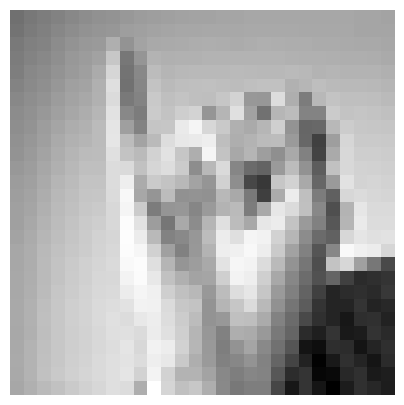

The predicted value is : i
The real value is : i


In [88]:
idx = np.random.randint(len(y_test))
plot_number(x_test[idx].reshape(28,28))
calc, _ = forward(modelInitial, x_test[idx].reshape(-1, 1))
pred = np.argmax(calc, axis=0)[0]

print(f'The predicted value is : {alphabet[pred]}')
print(f'The real value is : {alphabet[y_test[idx]]}')

### Conclusion




In this activity, we were able to design and implement a fully connected deep neural network using NumPy for image classification on Kaggle's ASL dataset. The data was preprocessed carefully by splitting the data into two separate labels, normalizing the input features, and creating proper training, validation, and test splits to ensure appropriate evaluation.

For the network architecture, two hidden layers with ReLU activation functions were implemented along with He initialization. This helped to keep the network's training stable and ensure effective gradient flow. We also trained the model using mini-batch gradient descent and further optimized it with a softmax and cross-entropy loss function. This enabled the network to be trained quickly without needing to rely on any high-level libraries for deep learning.

The final model achieved test accuracies between 75% and 80%, surpassing the minimum performance requirement of 70%. In addition, the exercise allowed us to better understand how a fully connected neural network operates internally, including the forward pass, backpropagation and the decisions made during network creation.